In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import math
import matplotlib.pyplot as plt

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:
THRESHOLD_ERROR_VALUE = 0.01

def generate_random_vector(size):
    return np.random.normal(0, 1, size)

def generate_random_matrix(row, col):
    columns = []
    for i in range(col):
        columns.append(generate_random_vector(row))
    return np.stack(columns, axis=1)

def minimizer_function(q_mat, c):
    return np.matmul(np.linalg.inv(q_mat), c)

def fx_cal(q_mat, c, x):
    part_1 = np.matmul(np.transpose(x), np.matmul(q_mat, x))
    part_1 = part_1 * 0.5
    part_2 = np.matmul(np.transpose(x), c)
    return part_1 - part_2

def calculate_coordinate_diff(x_k, x_min):
    return np.linalg.norm(x_k - x_min)

def get_orthogonal_vector(x1):
    x2 = np.array(np.random.normal(0, 1, len(x1)))
    u1 = x1 / np.linalg.norm(x1)
    x2_u1 = np.matmul(x2, np.transpose(u1))
    x2_proj_u1 = x2_u1 * u1
    residual = x2 - x2_proj_u1

    u2 = residual / np.linalg.norm(residual)
    return u2

In [16]:
def apply_gradient_descent(Q_mat, x_initialial, c, alpha, use_momentum=False, beta=0, x_prev=None, x_min=None,
                           use_min_direction=False, use_orthogonal_direction=False):
    pk = np.matmul(Q_mat, x_initialial) - c
    y = pk * alpha
    z = np.zeros(len(y))

    if use_momentum:
        if use_min_direction:
            z = beta * (x_min - x_initialial)
        elif use_orthogonal_direction:
            orthogonal = get_orthogonal_vector(pk)
            z = beta * orthogonal
        else:
            z = beta * (x_initialial - x_prev)
    return x_initialial - y + z

def angle_value(x_k_plus_1, x_k, x_k_min):
    x_k_plus_1_x_k_diff = x_k_plus_1 - x_k
    x_k_min_x_k_diff = x_k_min - x_k
    x_k_plus_1_x_k_diff_distance = np.linalg.norm(x_k_plus_1_x_k_diff)
    x_k_min_x_k_diff_distance = np.linalg.norm(x_k_min_x_k_diff)
    product = np.matmul(np.transpose(x_k_plus_1_x_k_diff), x_k_min_x_k_diff)
    product = product / (x_k_plus_1_x_k_diff_distance * x_k_min_x_k_diff_distance)
    return product

def optimal_alpha_cal(Q, x_initialial, c):
    pk = np.matmul(Q, x_initialial) - c
    numerator = np.matmul(np.transpose(pk), pk)
    denominator = np.matmul(np.transpose(pk), np.matmul(Q, pk))

    return numerator / denominator


In [17]:
def output_log(val):
    output = []
    for item in val:
        output.append(np.log(item))
    return output

def plot_gradient_descent_plots(x_axis, f_x_output, angle, plot_name):
    # print(f_x_output)

    plt.plot(x_axis, f_x_output)
    plt.xlabel(f'iterations {len(x_axis)}')
    plt.ylabel(f'{plot_name} Loss')
    plt.show()

    f_x_output_log = output_log(f_x_output)
    plt.plot(x_axis, f_x_output_log)
    plt.xlabel('iterations')
    plt.ylabel(f'{plot_name} Log Loss')
    plt.show()

    plt.plot(x_axis, angle)
    plt.xlabel('Iterations')
    plt.ylabel(f'{plot_name} Iterate Movement (Angle) ')
    plt.show()

def optimal_alpha_beta(Q, c, x_initialial, x_prev):
    pk = np.matmul(Q, x_initialial) - c
    qk = x_initialial - x_prev

    const_1 = np.matmul(np.transpose(pk), np.matmul(Q, pk))
    const_2 = np.matmul(np.transpose(qk), np.matmul(Q, qk))
    const_3 = np.matmul(np.transpose(pk), np.matmul(Q, qk))

    alpha_numerator = (np.matmul(np.transpose(pk), pk) * const_2) - (np.matmul(np.transpose(qk), pk) * const_3)
    alpha_denominator = (const_1 * const_2 - math.pow(const_3, 2))
    alpha = alpha_numerator / alpha_denominator

    beta_numerator = alpha * const_3 - np.matmul(np.transpose(qk), pk)
    beta = beta_numerator / const_2

    return alpha, beta


In [18]:
def gradient_descent(c, Q, x_initialial, x_min, f_max, f_min, alpha=0.05, beta=0.05,
                     use_momentum=False, use_optimal_alpha=False, use_min_direction=False,
                     use_orthogonal_direction=False, use_optimal_alpha_and_beta=False, plot_graph=""):
    f_x_output = []
    x_axis = []

    angle = []
    x_prev = x_initialial
    x_values = [x_initialial]
    for i in range(500000):
        if use_optimal_alpha:
            alpha = optimal_alpha_cal(Q, x_initialial, c)

        x_axis.append(i+1)
        f_x_output.append(calculate_coordinate_diff(x_initialial, x_min))

        if use_momentum:
            if use_optimal_alpha_and_beta:
                if len(x_values) > 1:
                    alpha, beta = optimal_alpha_beta(Q, c, x_initialial, x_values[i-1])
                    x_initialial = apply_gradient_descent(Q, x_initialial, c, alpha, use_momentum, beta,
                                                       x_values[i-1], x_min, use_min_direction,
                                                       use_orthogonal_direction)
                else:
                    alpha = optimal_alpha_cal(Q, x_initialial, c)
                    x_initialial = apply_gradient_descent(Q, x_initialial, c, alpha)

            else:
                x_initialial = apply_gradient_descent(Q, x_initialial, c, alpha, use_momentum, beta,
                                                   x_values[i-1], x_min, use_min_direction, use_orthogonal_direction)
        else:
            x_initialial = apply_gradient_descent(Q, x_initialial, c, alpha)

        x_values.append(x_initialial)
        angle.append(angle_value(x_initialial, x_prev, x_min))
        x_prev = x_initialial

        if f_x_output[-1] < THRESHOLD_ERROR_VALUE:
            break
    plot_gradient_descent_plots(x_axis, f_x_output, angle, plot_graph)


In [19]:
###### INITIALIZATION
A_mat = generate_random_matrix(10, 10)
Q = np.matmul(np.transpose(A_mat), A_mat)
c = generate_random_vector(10)
vt = np.transpose(c)
x_initial = generate_random_vector(10)

x_min = minimizer_function(Q, c)
f_max = fx_cal(Q, c, x_initial)
f_min = fx_cal(Q, c, x_min)

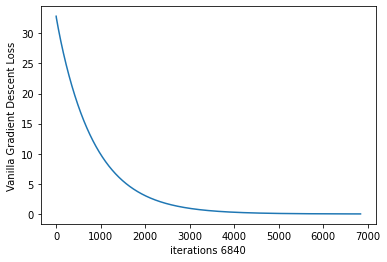

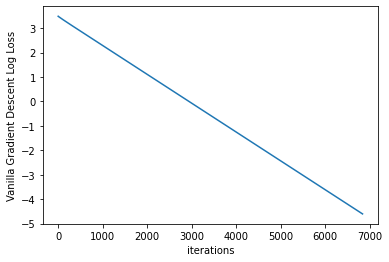

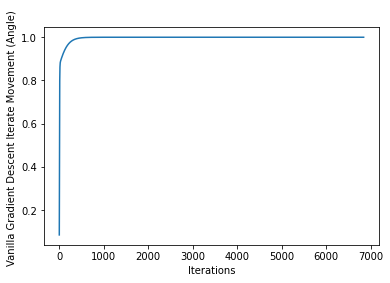

In [20]:
##### PLOTS ----- 
gradient_descent(c, Q, x_initial, x_min, f_max, f_min, plot_graph="Vanilla Gradient Descent")

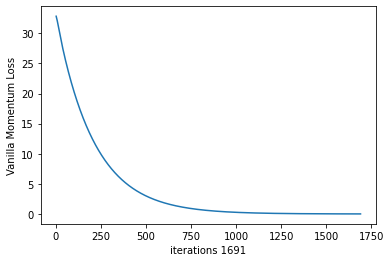

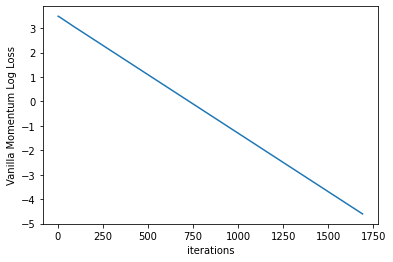

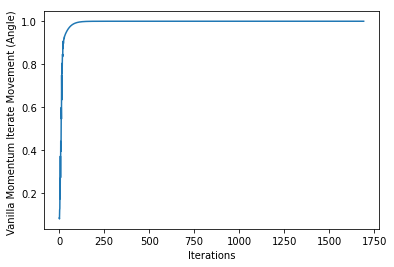

In [21]:
gradient_descent(c, Q, x_initial, x_min, f_max, f_min, alpha=0.06, beta=0.7, use_momentum=True, plot_graph="Vanilla Momentum")

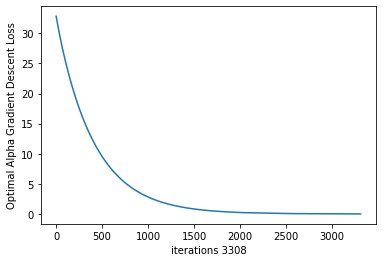

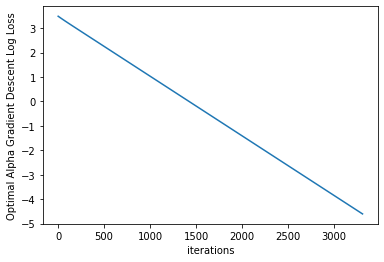

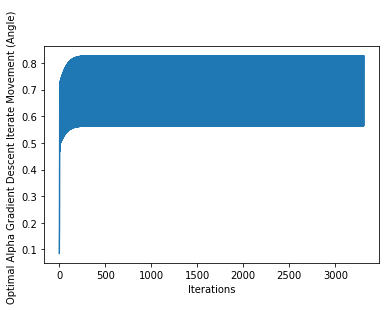

In [22]:
gradient_descent(c, Q, x_initial, x_min, f_max, f_min, use_optimal_alpha=True, plot_graph="Optimal Alpha Gradient Descent")

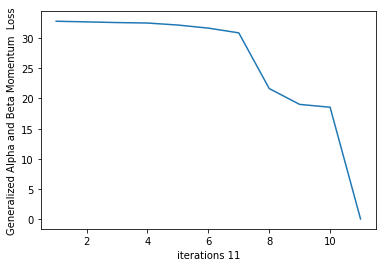

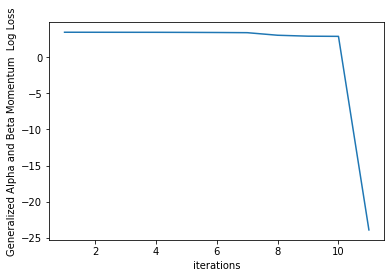

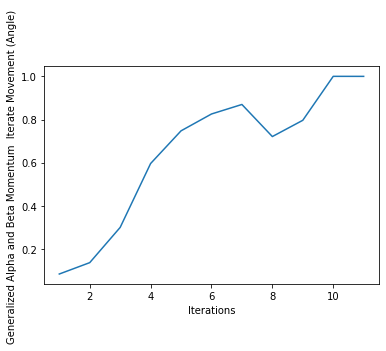

In [23]:
gradient_descent(c, Q, x_initial, x_min, f_max, f_min, use_momentum=True, use_optimal_alpha_and_beta=True, plot_graph="Generalized Alpha and Beta Momentum ")

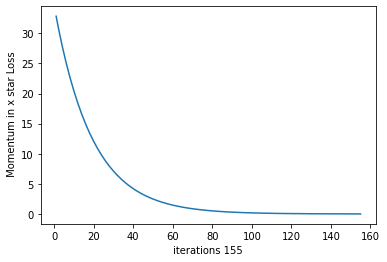

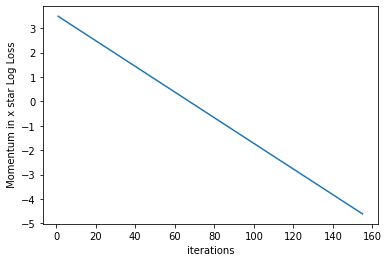

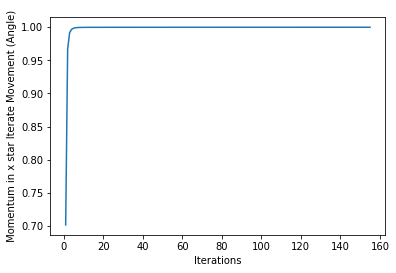

In [24]:
gradient_descent(c, Q, x_initial, x_min, f_max, f_min, use_momentum=True, use_min_direction=True, plot_graph=" Momentum in x star")

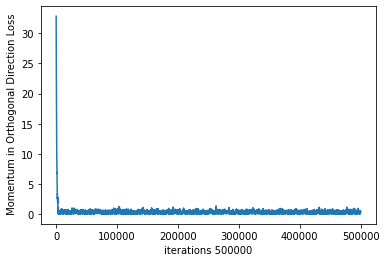

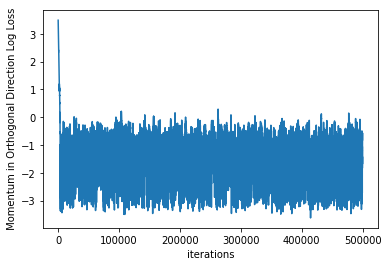

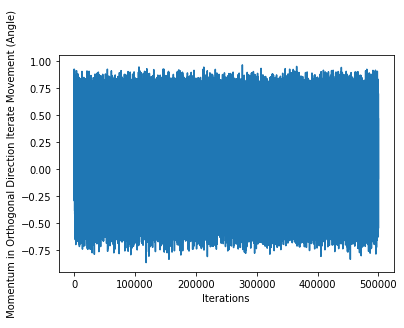

In [25]:
gradient_descent(c, Q, x_initial, x_min, f_max, f_min, use_momentum=True, use_orthogonal_direction=True, plot_graph=" Momentum in Orthogonal Direction")